# Slew Rate Calculations

### 1.0 Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate as integrate

### 1.1 Defining variables

In [2]:
L=(42/180)*np.pi #Rad, latitude of OGS in radians
R_e= 6.4*1e6 #m, radius of earth
h= 500*1e3 #m, orbit height
T_e=24*60*60 #s, one day
T_s=90*60 #s, period of one orbit for sat
a= (45/180)*np.pi #Rad, orbital inclination of sat


### 1.2 Defining auxilary functions

In [3]:
#Both time notations Josh uses
def t_e(t):
    return((2*np.pi*t)/T_e)
def t_s(t):
    return((2*np.pi*t)/T_s)
#Three aux functions
def u(t):
    result=np.sin(L)*np.cos(t_e(t))*np.cos(t_s(t))+np.sin(L)*np.sin(t_e(t))*np.cos(a)*np.sin(t_s(t))-1*np.cos(L)*np.sin(a)*np.sin(t_s(t))
    return(result)
def v(t):
    result=-1*np.sin(t_e(t))*np.cos(t_s(t))+np.cos(t_e(t))*np.cos(a)*np.sin(t_s(t))
    return(result)
def w(t):
    result=np.cos(L)*np.cos(t_e(t))*np.cos(t_s(t))+np.cos(L)*np.sin(t_e(t))*np.cos(a)*np.sin(t_s(t))+np.sin(L)*np.sin(a)*np.sin(t_s(t))
    return(result)


## 1.3 Azimuth

In [4]:
def z_1(t):
    result=(R_e+h)*(u(t)+1j*v(t))
    return(result)
def z_2(t):
    result=(-R_e)/np.sin(L)
    return(result)    
def arg(x,y):
    if x>0 and y>=0:
        return(np.arctan(y/x))
    elif x<0:
        return(np.pi+np.arctan(y/x))
    elif (x>0) and (y<0):
        return(2*np.pi+np.arctan(y/x))
    elif (x==0) and (y>0):
        return(ni.pi/2)
    elif (x==0) and (y<0):
        return((3/2)*np.pi)
    
def azimuth(t):
    result=np.pi-arg(u(t),v(t))
    return(result)
    
  

In [5]:
print(z_1(10))

(4574527.546350656+51751.39340664466j)


In [6]:
t_1=np.linspace(0.1,24*60*60,10000)
az_angles_calc=list()
for n in t_1:
    az_angles_calc.append(azimuth(n))

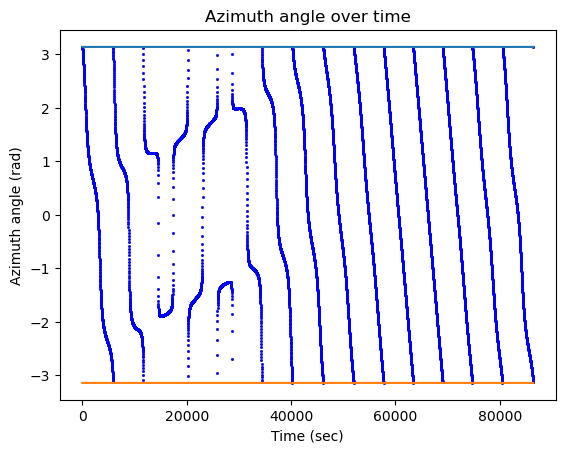

In [8]:

plt.plot(t_1,az_angles_calc,'bs',ms=1)
plt.plot(t_1,np.pi*(t_1/t_1))
plt.plot(t_1,-np.pi*(t_1/t_1))
plt.title("Azimuth angle over time")
plt.xlabel("Time (sec)")
plt.ylabel("Azimuth angle (rad)")
plt.show()

### 1.4 Elevation

In [9]:
def z_3(t):
    result=u(t)**2-v(t)**2+1j*w(t)
    return(result)
def elevation(t):
    result=arg(u(t)**2-v(t)**2,w(t))
    return(result)

In [10]:
elev_angles_calc=list()
t_2=np.linspace(0.1,24*60*60,int(1e6))
for n in t_2:
    elev_angles_calc.append(elevation(n))


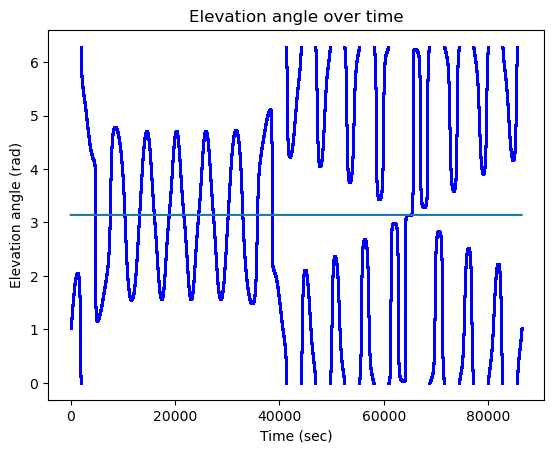

In [11]:
plt.plot(t_2,elev_angles_calc,'bs',ms=1)
plt.plot(t_2,np.pi*(np.ones(len(t_2))))
plt.title("Elevation angle over time")
plt.xlabel("Time (sec)")
plt.ylabel("Elevation angle (rad)")
plt.show()

Plot both together

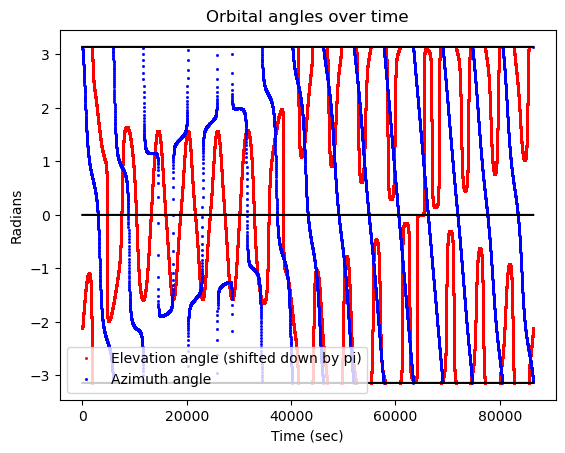

In [13]:
plt.plot(t_2,elev_angles_calc-np.ones(len(elev_angles_calc))*np.pi,'rs',ms=1,label='Elevation angle (shifted down by pi)')
plt.plot(t_1,az_angles_calc,'bs',ms=1,label='Azimuth angle')
plt.title("Orbital angles over time")
plt.xlabel("Time (sec)")
plt.ylabel("Radians")
#Plot out lines for easier viewing
plt.plot(t_1,np.pi*(t_1/t_1),'k')
plt.plot(t_1,-np.pi*(t_1/t_1),'k')
plt.plot(t_1,0*(t_1/t_1),'k')
plt.legend()
plt.show()


Eliminate times when the elevation angle is below the horizon

/var/folders/dn/8mgvm9616h162m2k9rd_y5mh0000gn/T/ipykernel_33486/702500283.py:1: RuntimeWarning: invalid value encountered in sqrt
  root=np.sqrt(elev_angles_calc-(np.ones(len(elev_angles_calc))*np.pi))


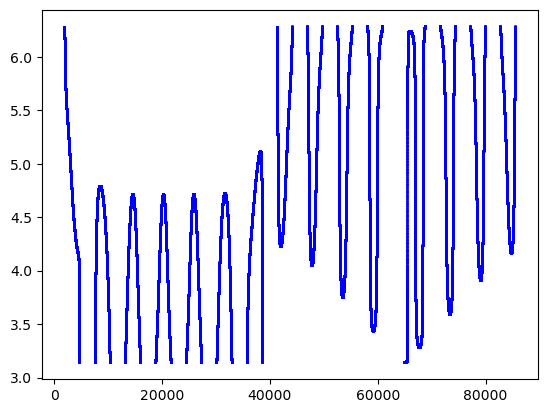

In [14]:
root=np.sqrt(elev_angles_calc-(np.ones(len(elev_angles_calc))*np.pi))
contact_elev_angles=root**2 +(np.ones(len(elev_angles_calc))*np.pi)
#corrector is a list of 1s and np.nans, with np.nan present where the sat is below horizon
corrector=contact_elev_angles/contact_elev_angles
plt.plot(t_2,contact_elev_angles,'bs',ms=1)
plt.show()

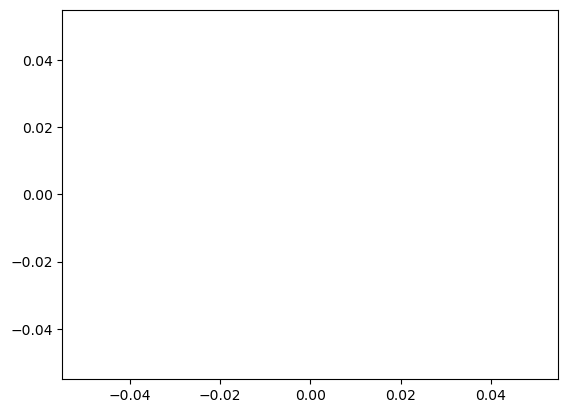

[nan nan nan ... nan nan nan]


In [15]:
plt.plot(t_1,az_angles_calc*corrector[:len(az_angles_calc)],'bs',ms=1)
plt.show()
print(az_angles_calc*corrector[:len(az_angles_calc)])

# 2.0 Slew Rates Using Astropy's Skycoord class

Here I follow the steps outlined on this tutorial https://docs.astropy.org/en/latest/coordinates/satellites.html# 

### 2.1 Imports

In [ ]:
import astropy.units as u
from astropy.coordinates import AltAz, EarthLocation, SkyCoord
from astropy.time import Time
from sgp4.api import Satrec
from sgp4.api import SGP4_ERRORS

### 2.2 Setting up the OGS location

In [ ]:
OGS=EarthLocation(lat=41.87 * u.deg, lon=-87.62 * u.deg, height=176 * u.m)
utcoffset = -5 * u.hour  # Central Daylight Time
time = Time("2024-7-12 23:00:00") - utcoffset

### 2.3 Setting up ISS position

In [ ]:
s='1 25544U 98067A   24280.57443646  .00031627  00000+0  57278-3 0  9995'
t='2 25544  51.6391 123.6698 0009280  42.2498   5.0482 15.49313621475820'
satellite = Satrec.twoline2rv(s, t)
time = Time(2460588.1253356, format='jd')
error_code, teme_p, teme_v = satellite.sgp4(time.jd1, time.jd2)  # in km and km/s
#if error_code != 0:
#    raise RuntimeError(SGP4_ERRORS[error_code])

### 2.41 Finding alt and az with skyCoord object

In [ ]:
#c = SkyCoord(x=588,y=1853,z=-2173,unit='km',obstime=time,frame='teme')
c = SkyCoord(x=teme_p[0],y=teme_p[1],z=teme_p[2],unit='km',obstime=time,frame='teme')

In [ ]:
altaz = c.transform_to(AltAz(obstime=time, location=OGS))
print(f"Altitude = {altaz.alt:.2}")
print(f"Azimuth = {altaz.az:.2}")

### 2.42 Finding alt and az with TEME object

In [ ]:
from astropy.coordinates import TEME, CartesianDifferential, CartesianRepresentation
from astropy import units as u
teme_p = CartesianRepresentation(teme_p*u.km)
teme_v = CartesianDifferential(teme_v*(u.km/u.s))
teme = TEME(teme_p.with_differentials(teme_v), obstime=time)

The intermediate step of manually setting up a topocentric ITRS frame is necessary in order to avoid the change in stellar aberration that would occur if a direct transform from geocentric to topocentric coordinates using transform_to was used. Please see the documentation of the ITRS frame for more details.

In [ ]:
from astropy.coordinates import ITRS
itrs_geo = teme.transform_to(ITRS(obstime=time))

In [ ]:
from astropy.coordinates import EarthLocation, AltAz
#siding_spring = EarthLocation.of_site('aao')  
topo_itrs_repr = itrs_geo.cartesian.without_differentials() - OGS.get_itrs(time).cartesian
itrs_topo = ITRS(topo_itrs_repr, obstime = time, location=OGS)
aa = itrs_topo.transform_to(AltAz(obstime=time, location=OGS))
print(f"Altitude = {aa.alt:.2}")
print(f"Azimuth = {aa.az:.2}")

## 2.5 Now to plot out alt and az over time

In [ ]:
def ISS_alt_az(observatory_loc,time,LE2=['1 25544U 98067A   24280.57443646  .00031627  00000+0  57278-3 0  9995'
,'2 25544  51.6391 123.6698 0009280  42.2498   5.0482 15.49313621475820']):
    # Set up satrack
    ISS_track= Satrec.twoline2rv(LE2[0], LE2[1])
    